In [2]:
#camera calibration
import numpy as np
import cv2
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

img = cv2.imread('calibration_wide/GOPR0069.jpg')
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

import pickle
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )

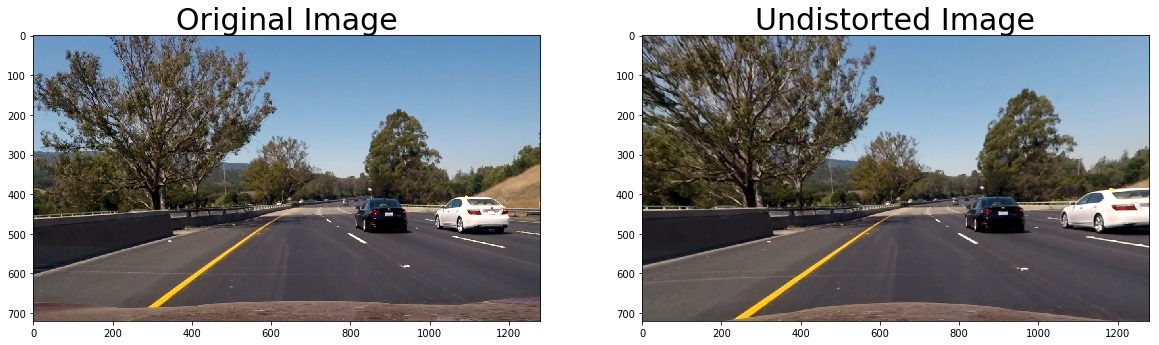

In [13]:
#image undistortion
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test6.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test6_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

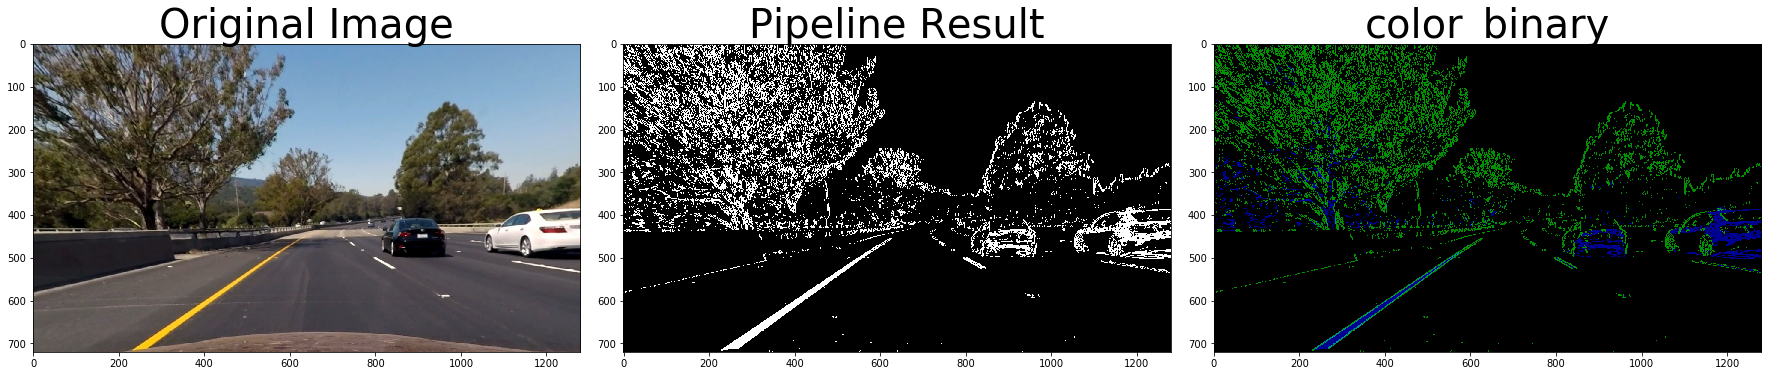

In [9]:
#color and gradient selection
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('test6_undist.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary ==1)|(sxbinary ==1)] = 1
    return combined_binary, color_binary

result, color_binary = pipeline2(image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap = 'gray')
ax2.set_title('Pipeline Result', fontsize=40)

from skimage import exposure
color_binary= exposure.adjust_gamma(color_binary, 0.1)  #调亮

ax3.imshow(color_binary)
ax3.set_title('color_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

True

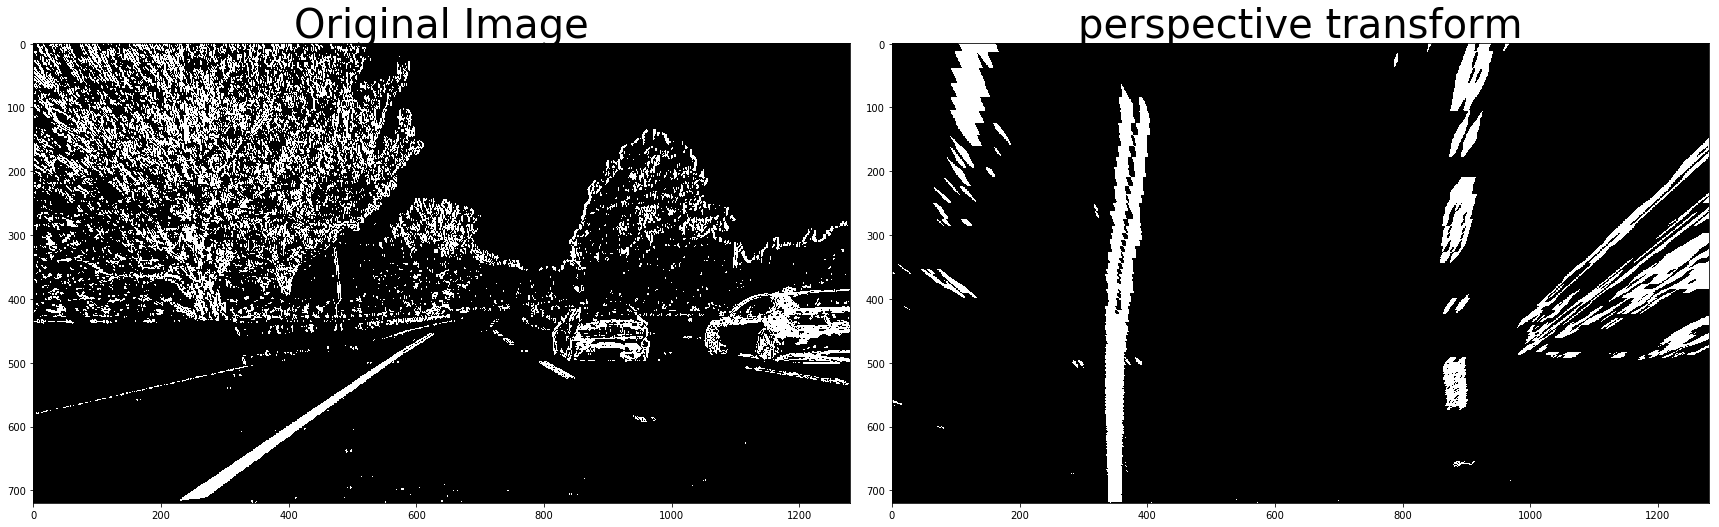

In [29]:
#perform perspective transform
#color and gradient selection
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('test6_undist.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary ==1)|(sxbinary ==1)] = 1
    return combined_binary, color_binary

result, color_binary = pipeline2(image)
#草蛋的地方[x,y]
src = np.float32([[625, 450], [720, 450], [1200, 720], [240, 720]])
dst = np.float32([[350, 0], [900, 0], [900, 720], [350, 720]])

img_size = (img.shape[1], img.shape[0])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(result,cmap = 'gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap = 'gray')
ax2.set_title('perspective transform', fontsize=40)

cv2.imwrite('warped.jpg',np.uint8(255*warped))

(720, 1280)


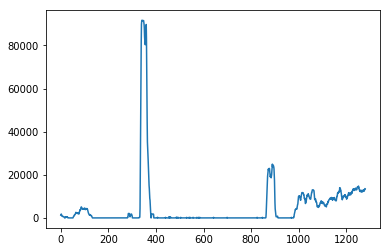

In [45]:
#detect lines
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
img = cv2.imread("warped.jpg",0)
print(np.shape(img))

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)


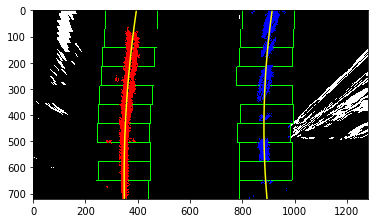

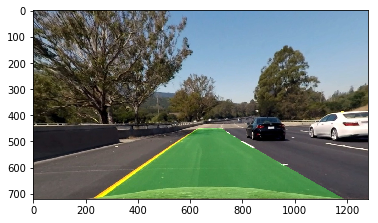

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

binary_warped = cv2.imread('warped.jpg',0)
#沿水平方向求直方图
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
#构造画布，将堆叠三个通道的binary_warped图像
out_img = np.dstack((binary_warped,binary_warped,binary_warped))

#寻找直方图的两个波峰
midpoint = np.int(histogram.shape[0]/2) #直方图的中点，上图来看中点正好可以分割两个波峰
leftx_base = np.argmax(histogram[:midpoint]) #左侧起点
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#垂直堆叠的滑窗层数
nwindows = 10
#设定滑窗的高度
window_height = np.int(binary_warped.shape[0]/nwindows)
#设定滑窗的宽度
margin = 100
#获取binary_warped图像中所有非零像素点的坐标
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

#当前波峰位置
leftx_current = leftx_base
rightx_current = rightx_base

#滑窗阈值，即若小于这个阈值，则此滑窗位置不应该是波峰的位置
minpix = 50

left_lane_inds = []
right_lane_inds = []

#挨个处理滑窗
for window in range(nwindows):
    #确定每一层滑窗内道路线的y坐标搜索范围，也是滑窗顶点坐标
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height

    #确定每一层滑窗内左右道路线的波峰x坐标搜索范围，也是滑窗顶点坐标
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    #画出左右滑窗
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
    
    #识别当前滑窗内的非零像素坐标
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    #append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    #若当前滑窗内非零像素大于阈值，则更新波峰坐标，否则沿用之前的，垂直堆叠
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
#concatenate the arrays of indices
'''
stack（）：沿着新的轴加入一系列数组。
vstack（）：堆栈数组垂直顺序（行）
hstack（）：堆栈数组水平顺序（列）。
dstack（）：堆栈数组按顺序深入（沿第三维）。
concatenate（）：连接沿现有轴的数组序列。
vsplit（）：将数组分解成垂直的多个子数组的列表。
'''
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


#获取左右滑窗内所有非零像素坐标
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

#二次拟合
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

#visualization
#You're fitting for f(y), rather than f(x),
#because the lane lines in the warped image are near vertical and
#may have the same x value for more than one y value
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]

plt.imshow(out_img)
plt.plot(left_fitx,ploty,color='yellow')
plt.plot(right_fitx,ploty,color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()
    
#drawing, project back
undist = cv2.imread('test6_undist.jpg')

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#很关键
# np.flipud:Flip the entries in each column in the up/down direction
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, True, (0,255, 0))


#草蛋的地方[x,y]
src = np.float32([[625, 450], [720, 450], [1200, 720], [240, 720]])
dst = np.float32([[350, 0], [900, 0], [900, 720], [350, 720]])

Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#opencv BGR, matplotlib RGB
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)

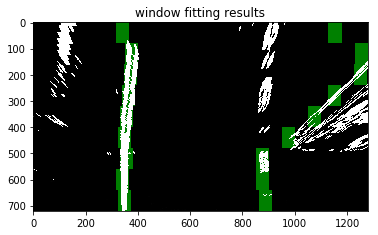

In [8]:
#另一种寻找车道线的方法，卷积滑窗
#结果很不好
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

warped = mpimg.imread('warped.jpg')
#设定滑窗的宽和高
window_width = 50
window_height = 80
margin = 100 #how much to slide

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] #存储左右道路线滑窗的窗口中心位置
    window = np.ones(window_width) #卷积核1*window_width
    
    #寻找初始左右道路线中心坐标
    #统计左右区域的水平方向像素直方图，分别用模板与直方图卷积
    #卷积响应最大的地方，即为道路线所在位置
    #y方向75%，x方向50%
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum)) - window_width/2
    
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum)) - window_width/2 + int(warped.shape[1]/2)
    
    #add to the list
    window_centroids.append((l_center, r_center))
    
    #遍历每层滑窗，寻找道路线中心位置
    for level in range(1, (int)(warped.shape[0]/window_height)):
        #截取一层图像，一个窗口高的图像,并沿水平方向统计直方图
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:],axis=0)
        #整层图像与预定义模板做卷积
        conv_signal = np.convolve(window, image_layer)
        offset = window_width/2
        #在上一步的左车道线坐标附近搜索更远处的左车道线
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        #在上一步的右车道线坐标附近搜索更远处的右车道线
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        window_centroids.append((l_center,r_center))
    
    return window_centroids

window_centroids = find_window_centroids(warped, window_width,window_height,margin)

#标记某个窗口范围内的像素为车道线
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])]=1
    return output


#若找到左右窗口，想办法画出来
if len(window_centroids) > 0:
    #为了区分左右，申明两个空的点集,TMD最后没有区分！！
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points==255)|((l_mask == 1))] = 255
        r_points[(r_points==255)|((r_mask==1))] = 255
    
    #添加左右两个点集
    template = np.array(r_points + l_points, np.uint8)
    # create a zero color channle 
    zero_channel = np.zeros_like(template)
    #标记滑窗为绿色
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)# making the original road pixels 3 color channels
    # overlay the orignal road image with window results
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

else:
    # If no window centers found, just display orginal road image
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
    
 